KONU: Üsküdar'da bulunan cam atık konteynerlerini dolaşacak araç için en kısa rotanın bulunması.

YÖNTEM: Problem TSP olarak kurgulanıp Genetik Algoritma metoduyla çözülmüştür.

In [1]:
from sys import maxsize
from time import time
from random import random, randint, sample
import numpy as np

In [2]:
import os
os.environ['PROJ_LIB']=r'C:\Users\user\Anaconda3\pkgs\proj4-5.2.0-ha925a31_1\Library\share'
from mpl_toolkits.basemap import Basemap

In [3]:
class Gen: #bir konteyner ((x, y) koordinatları olarak gösterilir)
    def __init__(self, mah, x, y):
        self.mah = mah
        self.x = x
        self.y = y
    
    def mesafe_ölç(self, gen):
        xMes = abs(self.x - gen.x)
        yMes = abs(self.y - gen.y)
        mesafe = (np.sqrt((xMes ** 2) + (yMes ** 2)))*111
        return mesafe
    
    def __repr__(self):
        return "(" + str(self.mah) + "," + str(self.x) + "," + str(self.y) + ")"

In [4]:
class Kromozom:  # Rota: Tek güzergah
    def __init__(self, genler):
        assert(len(genler) > 3)
        self.genler = genler
        self.__reset_params()

    def swap(self, gen_1, gen_2):
        self.genler[0]
        a, b = self.genler.index(gen_1), self.genler.index(gen_2)
        self.genler[b], self.genler[a] = self.genler[a], self.genler[b]
        self.__reset_params()

    def ekle(self, gen):
        self.genler.append(gen)
        self.__reset_params()

    @property
    def fitness(self):
        if self.__fitness == 0:
            self.__fitness = 1 / self.gezi_maliyeti  # gezi maliyetini normalize
        return self.__fitness

    @property
    def gezi_maliyeti(self):  # rota uzunluğu
        if self.__gezi_maliyeti == 0:
            for i in range(len(self.genler)):
                orijin = self.genler[i]
                if i == len(self.genler) - 1:
                    mes = self.genler[0]
                else:
                    mes = self.genler[i+1]

                self.__gezi_maliyeti += orijin.mesafe_ölç(mes)

        return self.__gezi_maliyeti

    def __reset_params(self):
        self.__gezi_maliyeti = 0
        self.__fitness = 0
        
    def __repr__(self):
        return "(" + str(self.genler) + "," + str(self.__reset_params()) + ")"

In [5]:
class Populasyon:
    def __init__(self, bireyler):
        self.bireyler = bireyler

    @staticmethod
    def gen_bireyler(sz, genler):
        bireyler = []
        for _ in range(sz):
            bireyler.append(Kromozom(sample(genler, len(genler))))
        return Populasyon(bireyler)

    def ekle(self, rota):
        self.bireyler.append(rota)

    def çıkar(self, rota):
        self.bireyler.remove(rota)

    def enuygunu_al(self):
        enuygun = self.bireyler[0]
        for rota in self.bireyler:
            if rota.fitness > enuygun.fitness:
                enuygun = rota
        return enuygun
    
    def __repr__(self):
        return "(" + str(self.bireyler) + ")"

In [6]:
def evrim(pop, turnuva_büyüklüğü, mut_oran):
    yeni_jenerasyon = Populasyon([])
    pop_büyüklüğü = len(pop.bireyler)
    elitizm_num = pop_büyüklüğü // 2

    # Elitizm
    for _ in range(elitizm_num):
        enuygun = pop.enuygunu_al()
        yeni_jenerasyon.ekle(enuygun)
        pop.çıkar(enuygun)

    # Çaprazlama
    for _ in range(elitizm_num, pop_büyüklüğü):
        ebeveyn_1 = seçim(yeni_jenerasyon, turnuva_büyüklüğü)
        ebeveyn_2 = seçim(yeni_jenerasyon, turnuva_büyüklüğü)
        çocuk = çaprazla(ebeveyn_1, ebeveyn_2)
        yeni_jenerasyon.ekle(çocuk)

    # Mutasyon
    for i in range(elitizm_num, pop_büyüklüğü):
        mutasyon(yeni_jenerasyon.bireyler[i], mut_oran)

    return yeni_jenerasyon

def çaprazla(ebeveyn_1, ebeveyn_2):
    def ebeveyn1_ile_doldur(çocuk, ebeveyn, genler_n):
        start_at = randint(0, len(ebeveyn.genler)-genler_n-1)
        finish_at = start_at + genler_n
        for i in range(start_at, finish_at):
            çocuk.genler[i] = ebeveyn_1.genler[i]

    def ebeveyn2_ile_doldur(çocuk, ebeveyn):
        j = 0
        for i in range(0, len(ebeveyn.genler)):
            if çocuk.genler[i] == None:
                while ebeveyn.genler[j] in çocuk.genler:
                    j += 1
                çocuk.genler[i] = ebeveyn.genler[j]
                j += 1

    genler_n = len(ebeveyn_1.genler)
    çocuk = Kromozom([None for _ in range(genler_n)])
    ebeveyn1_ile_doldur(çocuk, ebeveyn_1, genler_n // 2)
    ebeveyn2_ile_doldur(çocuk, ebeveyn_2)

    return çocuk

In [18]:
def mutasyon(birey, oran):
    for _ in range(len(birey.genler)):
        if random() < oran:
            sel_genler = sample(birey.genler, 2)
            birey.swap(sel_genler[0], sel_genler[1])


def seçim(populasyon, rakipler_n):
    return Populasyon(sample(populasyon.bireyler, rakipler_n)).enuygunu_al()


def ga(genler, pop_büyüklüğü, n_gen, turnuva_büyüklüğü, mut_oran, verbose=1):
    populasyon = Populasyon.gen_bireyler(pop_büyüklüğü, genler)
    gelişim_aşamaları = {'maliyet': [populasyon.enuygunu_al().gezi_maliyeti]}
    sayaç, jenerasyonlar, min_maliyet = 0, 0, maxsize

    if verbose:
        print("-- TSP-GA -- başlıyor...")

    start_time = time()
    while sayaç < n_gen:
        populasyon = evrim(populasyon, turnuva_büyüklüğü, mut_oran)
        maliyet = round(populasyon.enuygunu_al().gezi_maliyeti, 2)

        if maliyet < min_maliyet:
            sayaç, min_maliyet = 0, maliyet
        else:
            sayaç += 1

        jenerasyonlar += 1
        gelişim_aşamaları['maliyet'].append(maliyet)

    total_time = round(time() - start_time, 6)

    if verbose:
        print("-- TSP-GA -- {} jenerasyon sonra {} saniyede bitti"\
              .format(jenerasyonlar, total_time))
        print("-- TSP-GA -- Minimum gezi maliyeti {} KM".format(min_maliyet))

    gelişim_aşamaları['jenerasyonlar'] = jenerasyonlar
    gelişim_aşamaları['toplam_zaman'] = total_time
    gelişim_aşamaları['rota'] = populasyon.enuygunu_al()

    return gelişim_aşamaları

In [15]:
import matplotlib.pyplot as plt
import pandas as pd

In [16]:
def genleri_al(dosya_adı, sample_n=0):
    df = pd.read_csv(dosya_adı)
    genler = [Gen(row['MAH'], round(row['X'],6), round(row['Y'],6))
             for _, row in df.iterrows()]

    return genler if sample_n <= 0 else sample(genler, sample_n)

In [17]:
konteynır_listesi = []
konteynır_listesi = genleri_al('uskudar4.csv')

In [50]:
gelişim_aşamaları = ga(genler=konteynır_listesi, pop_büyüklüğü=500, n_gen=20, \
                       turnuva_büyüklüğü=20, mut_oran=0.01, verbose=1)

-- TSP-GA -- başlıyor...
-- TSP-GA -- 66 jenerasyon sonra 10.820772 saniyede bitti
-- TSP-GA -- Minimum gezi maliyeti 40.89 KM


In [40]:
def plot(maliyetler, birey, save_to=None):
    plt.figure(1)
    plt.subplot(121)
    plot_ga_yakınsama(maliyetler)

    plt.subplot(122)
    plot_rota(birey)

    if save_to is not None:
        plt.savefig(save_to)
        plt.close()
    else:
        plt.show()

def plot_ga_yakınsama(maliyetler):
    x = range(len(maliyetler))
    plt.title("GA Yakınsama")
    plt.xlabel('jenerasyon')
    plt.ylabel('maliyet (KM)')
    plt.text(x[len(x) // 2], maliyetler[0], 'min maliyet: {} KM'\
             .format(maliyetler[-1]), ha='center', va='center')
    plt.plot(x, maliyetler, '-')


def plot_rota(birey):
    m = Basemap(projection='lcc', resolution=None,
                width=5E6, height=5E6,
                lat_0=-15, lon_0=-56)

    plt.axis('off')
    plt.title("En Kısa Rota")

    for i in range(0, len(birey.genler)):
        x, y = m(birey.genler[i].y, birey.genler[i].x)

        plt.plot(x, y, 'ok', c='r', markersize=5)
        if i == len(birey.genler) - 1:
            x2, y2 = m(birey.genler[0].y, birey.genler[0].x)
        else:
            x2, y2 = m(birey.genler[i+1].y, birey.genler[i+1].x)

        plt.plot([x, x2], [y, y2], 'k-', c='r')

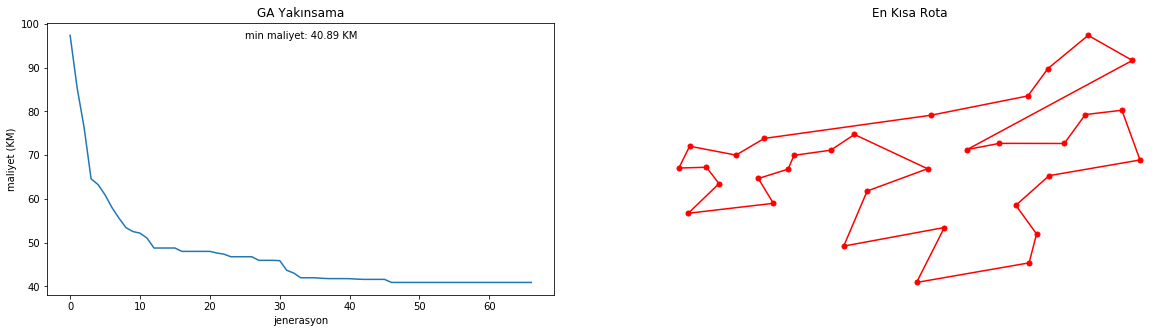

In [51]:
plt.figure(figsize=(20,5))
plot(gelişim_aşamaları['maliyet'], gelişim_aşamaları['rota'])

In [52]:
gelişim_aşamaları

{'maliyet': [97.37333689743642,
  85.39,
  76.3,
  64.57,
  63.26,
  60.9,
  57.97,
  55.56,
  53.4,
  52.52,
  52.16,
  51.04,
  48.76,
  48.76,
  48.76,
  48.76,
  47.99,
  47.99,
  47.99,
  47.99,
  47.99,
  47.62,
  47.36,
  46.77,
  46.77,
  46.77,
  46.77,
  45.94,
  45.94,
  45.94,
  45.87,
  43.67,
  43.04,
  41.96,
  41.96,
  41.96,
  41.84,
  41.77,
  41.77,
  41.77,
  41.75,
  41.65,
  41.59,
  41.59,
  41.59,
  41.59,
  40.89,
  40.89,
  40.89,
  40.89,
  40.89,
  40.89,
  40.89,
  40.89,
  40.89,
  40.89,
  40.89,
  40.89,
  40.89,
  40.89,
  40.89,
  40.89,
  40.89,
  40.89,
  40.89,
  40.89,
  40.89],
 'jenerasyonlar': 66,
 'toplam_zaman': 10.820772,
 'rota': ([(KÜPLÜCE,41.035775,29.056574), (KÜÇÜKSU,41.065622,29.071771), (KANDİLLİ,41.069532,29.061323), (KULELİ,41.059455,29.059126), (ÇENGELKÖY,41.051816,29.059435), (BEYLERBEYİ,41.042332,29.046226), (SULTANTEPE,41.028428,29.022166), (MİMAR SİNAN,41.022978,29.019766), (AZİZ MAHMUT HÜDAYİ,41.022845,29.011077), (SALACAK,41.0